In [1]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import numpy as np
from numpy.linalg import eig, inv
import os
import pandas as pd

In [2]:
def ls_ellipsoid(xx,yy,zz):                                  
    #finds best fit ellipsoid. Found at http://www.juddzone.com/ALGORITHMS/least_squares_3D_ellipsoid.html
    #least squares fit to a 3D-ellipsoid
    #  Ax^2 + By^2 + Cz^2 +  Dxy +  Exz +  Fyz +  Gx +  Hy +  Iz  = 1
    #
    # Note that sometimes it is expressed as a solution to
    #  Ax^2 + By^2 + Cz^2 + 2Dxy + 2Exz + 2Fyz + 2Gx + 2Hy + 2Iz  = 1
    # where the last six terms have a factor of 2 in them
    # This is in anticipation of forming a matrix with the polynomial coefficients.
    # Those terms with factors of 2 are all off diagonal elements.  These contribute
    # two terms when multiplied out (symmetric) so would need to be divided by two
    
    # change xx from vector of length N to Nx1 matrix so we can use hstack
    x = xx[:,np.newaxis]
    y = yy[:,np.newaxis]
    z = zz[:,np.newaxis]
    
    #  Ax^2 + By^2 + Cz^2 +  Dxy +  Exz +  Fyz +  Gx +  Hy +  Iz = 1
    J = np.hstack((x*x,y*y,z*z,x*y,x*z,y*z, x, y, z))
    K = np.ones_like(x) #column of ones
    
    #np.hstack performs a loop over all samples and creates
    #a row in J for each x,y,z sample:
    # J[ix,0] = x[ix]*x[ix]
    # J[ix,1] = y[ix]*y[ix]
    # etc.
    
    JT=J.transpose()
    JTJ = np.dot(JT,J)
    InvJTJ=np.linalg.inv(JTJ);
    ABC= np.dot(InvJTJ, np.dot(JT,K))

    # Rearrange, move the 1 to the other side
    #  Ax^2 + By^2 + Cz^2 +  Dxy +  Exz +  Fyz +  Gx +  Hy +  Iz - 1 = 0
    #    or
    #  Ax^2 + By^2 + Cz^2 +  Dxy +  Exz +  Fyz +  Gx +  Hy +  Iz + J = 0
    #  where J = -1
    eansa=np.append(ABC,-1)

    return (eansa)

In [8]:


def polyToParams3D(vec,printMe):                             
    #gets 3D parameters of an ellipsoid. Found at http://www.juddzone.com/ALGORITHMS/least_squares_3D_ellipsoid.html
    # convert the polynomial form of the 3D-ellipsoid to parameters
    # center, axes, and transformation matrix
    # vec is the vector whose elements are the polynomial
    # coefficients A..J
    # returns (center, axes, rotation matrix)
    
    #Algebraic form: X.T * Amat * X --> polynomial form
    
    if printMe: print('\npolynomial\n',vec)
    
    Amat=np.array(
    [
    [ vec[0],     vec[3]/2.0, vec[4]/2.0, vec[6]/2.0 ],
    [ vec[3]/2.0, vec[1],     vec[5]/2.0, vec[7]/2.0 ],
    [ vec[4]/2.0, vec[5]/2.0, vec[2],     vec[8]/2.0 ],
    [ vec[6]/2.0, vec[7]/2.0, vec[8]/2.0, vec[9]     ]
    ])
    
    if printMe: print('\nAlgebraic form of polynomial\n',Amat)
    
    #See B.Bartoni, Preprint SMU-HEP-10-14 Multi-dimensional Ellipsoidal Fitting
    # equation 20 for the following method for finding the center
    A3=Amat[0:3,0:3]
    A3inv=inv(A3)
    ofs=vec[6:9]/2.0
    center=-np.dot(A3inv,ofs)
    if printMe: print('\nCenter at:',center)
    
    # Center the ellipsoid at the origin
    Tofs=np.eye(4)
    Tofs[3,0:3]=center
    R = np.dot(Tofs,np.dot(Amat,Tofs.T))
    if printMe: print('\nAlgebraic form translated to center\n',R,'\n')
    
    R3=R[0:3,0:3]
    R3test=R3/R3[0,0]
    # print('normed \n',R3test)
    s1=-R[3, 3]
    R3S=R3/s1
    (el,ec)=eig(R3S)
    
    recip=1.0/np.abs(el)
    axes=np.sqrt(recip)
    if printMe: print('\nAxes are\n',axes  ,'\n')
    
    inve=inv(ec) #inverse is actually the transpose here
    if printMe: print('\nRotation matrix\n',inve)
    return (center,axes,inve)




In [9]:
def elcoef(img_name):
    #let us assume some definition of x, y and z
    #img_name = 'D:/data/seeds/598/val/1484717/1491988_Surface.ply'
    img = np.genfromtxt(img_name, skip_header = 7, skip_footer = 1)
    x = img[:,0]
    y = img[:,1]
    z = img[:,2]
    print('center of masses', np.mean(img, axis = 0))
    #get convex hull
    surface  = np.stack((x,y,z), axis=-1)
    #surface  = np.stack((conf.x,conf.y,conf.z), axis=-1)
    hullV    = ConvexHull(surface)
    lH       = len(hullV.vertices)
    hull     = np.zeros((lH,3))
    for i in range(len(hullV.vertices)):
        hull[i] = surface[hullV.vertices[i]]
    hull     = np.transpose(hull)         

    #fit ellipsoid on convex hull
    eansa            = ls_ellipsoid(hull[0],hull[1],hull[2]) #get ellipsoid polynomial coefficients

#    print("coefficients:"  , eansa)
    center,axes,inve = polyToParams3D(eansa,False)   #get ellipsoid 3D parameters
#     print("center:"        , center)
#     print("axes:"          , axes)
#     print("rotationMatrix:", inve)
    return(center,axes,inve)

In [10]:
elcoef('D:/seva/598_processing/val/1484717/1491988_Surface.ply')

center of masses [129.83198685  43.93653293 154.31712995]


ValueError: too many values to unpack (expected 3)

In [141]:
mainpath = 'D:/seva/598_processing/val'

In [142]:
#if not(os.path.isfile('tmean.csv') and os.path.isfile(mainpath+'/sh.csv')):
cip = []
for root, directories, filenames in os.walk(mainpath): 
    for filename in filenames:
        if filename[-3:] == 'ply':
            cip.append(os.path.join(root,filename))

In [139]:
len(cip)

4072

In [92]:
4072+1198

5270

In [63]:
ela = np.zeros((len(cip),10))
for i, filename in enumerate(cip):
    ela[i] = elcoef(filename)

In [64]:
np.savetxt('D:/seva/598_processing/val/ela.csv',ela[:,:9],delimiter=',', newline='\n')

In [135]:
print(cip[0][-27:-12])

1484727\1493208


In [143]:
D_out = 9
mainpath = 'D:/seva/598_processing/val'
ela = np.genfromtxt(mainpath+'/ela.csv', delimiter=',')
landmarks_frame = pd.DataFrame(data=ela,index=range(len(cip)),\
                               columns=['f'+str(i) for i in range(D_out)])
landmarks_frame.insert(0, 'file_name', \
                       [cip[i][-27:-12] for i in range(len(cip))])
landmarks_frame.to_csv(mainpath+'/el_paramters.csv', index=False)

In [86]:
landmarks_frame = pd.read_csv('D:/seva/598_processing/el_parameters.csv')
np.array(landmarks_frame.min()[1:])+np.ones(9)

In [106]:
landmarks_frame = pd.read_csv('D:/seva/598_processing/el_parameters.csv')
(landmarks_frame.max()[1:]).to_numpy()

array([-6.28e-06, -1.62e-05, -5.35e-06, 7.730000000000001e-05,
       0.000183897, 0.000125373, 0.018726644, 0.016954233, 0.018678133],
      dtype=object)

In [42]:
elcoef(cip[1])

array([[-0.99573311, -0.08936804, -0.02299853],
       [-0.08977578,  0.8804802 ,  0.46550501],
       [ 0.02135152, -0.46558347,  0.88474638]])

In [31]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

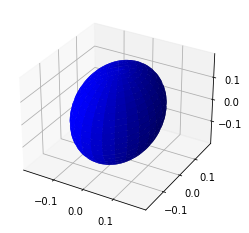

In [39]:


fig = plt.figure(figsize=plt.figaspect(1))  # Square figure
ax = fig.add_subplot(111, projection='3d')

#coefs = (69.34982626, 37.77689546, 36.27027196)  # Coefficients in a0/c x**2 + a1/c y**2 + a2/c z**2 = 1 
coefs = elcoef(cip[0])
# Radii corresponding to the coefficients:
rx, ry, rz = 1/np.sqrt(coefs)

# Set of all spherical angles:
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

# Cartesian coordinates that correspond to the spherical angles:
# (this is the equation of an ellipsoid):
x = rx * np.outer(np.cos(u), np.sin(v))
y = ry * np.outer(np.sin(u), np.sin(v))
z = rz * np.outer(np.ones_like(u), np.cos(v))

# Plot:
ax.plot_surface(x, y, z,  rstride=4, cstride=4, color='b')

# Adjustment of the axes, so that they all have the same span:
max_radius = max(rx, ry, rz)
for axis in 'xyz':
    getattr(ax, 'set_{}lim'.format(axis))((-max_radius, max_radius))

plt.show()

In [27]:
labels = np.zeros([len(cip),D_out])
for i in range(len(cip)):
    labels[i,:] = torch.tensor(np.genfromtxt(cip[i], delimiter='\n'))
tmean = np.zeros([4,D_out])
tmean[0,:] = np.mean(labels, axis = 0)
tmean[1,:] = np.std(labels, axis = 0)
tmean[2,:] = np.min(labels, axis = 0)
tmean[3,:] = np.max(labels, axis = 0)
numpy.savetxt("tmean.csv", tmean, delimiter=",")
landmarks_frame = pd.DataFrame(data=labels,index=range(len(cip)),\
                               columns=['f'+str(i) for i in range(D_out)])
landmarks_frame.insert(0, 'file_name', \
                       [cip[i][-24:-9] for i in range(len(cip))])
landmarks_frame.to_csv(mainpath+'/sh_paramters.csv', index=False)
#tmean = np.genfromtxt("tmean.csv", delimiter=',')

# find global minimum and maximum of ply coordinates

In [107]:
mainpath = 'D:/seva/598_processing/'

In [108]:
#if not(os.path.isfile('tmean.csv') and os.path.isfile(mainpath+'/sh.csv')):
cip = []
for root, directories, filenames in os.walk(mainpath): 
    for filename in filenames:
        if filename[-3:] == 'ply':
            cip.append(os.path.join(root,filename))

In [124]:
len(cip)

5270

In [110]:
img_name = cip[0]
img = np.genfromtxt(img_name, skip_header = 7, skip_footer = 1)


In [123]:
np.max(img, axis = 0)[0]

148.0

In [129]:
mins = [100, 100, 100]
maxs = np.zeros(3)
for i, img_name in enumerate(cip):
#     if i == 10:
#         break
    img = np.genfromtxt(img_name, skip_header = 7, skip_footer = 1)
    for j in range(3):
        if np.min(img, axis = 0)[j]<mins[j]:
            mins[j]=np.min(img, axis = 0)[j]
        if np.max(img, axis = 0)[j]>maxs[j]:
            maxs[j]=np.max(img, axis = 0)[j]   

In [133]:
maxs

array([240., 116., 243.])

In [144]:
center,axes, inve = polyToParams3D([-2.72172054e-05, -3.43395946e-05, -1.68379114e-05  3.69536673e-06
 -2.36337662e-05  7.80518302e-06  8.93983870e-03  9.06346229e-04
  6.79183928e-03], True)

SyntaxError: invalid syntax (<ipython-input-144-970f63158db0>, line 1)